# Projet 4: Convexité et Optimisation sous contrainte

## Préliminaires

Importation des packages

In [1]:
from math import *

import numpy as np
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

import pandas as pd  #pandas pour la gestion des données 
import matplotlib.pyplot as plt

# SciPy - Efficient mathematical calculation
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

Dans ce projet nous allons  implémenter le conditional gradient algorithm et l'algorithme du gradient projeté. Nous implémenterons ces deux méthodes de minimisation sous contraintes sur les ensembles convexes suivant:
- la boule l-2
- la boule l-1 



Nous considérons la fonction suivante à minimiser:
$$f(x)=2x^2+ 4x+2y^2 + 3y+5 $$

dont le gradient est:

$$∇f(x,y)= \begin{pmatrix}
4x+4\\
4y+3
\end{pmatrix}$$

Nous définissons ces différentes fonctions. Nous définissons également  une fonction initialisation pour générer des valeurs d'initialisation dans les contraintes que nous aurons définies ($\lVert (x,y) \rVert_1 \leq1$ dans le cas de la boule l1 et $\lVert (x,y) \rVert_2 \leq1$  dans le cas de la boule l2)

De plus on a que:  
$$\lVert ∇f(x_1,y_1)-∇f(x_2,y_2)\rVert_2 \leq 4 \lVert (x_1,y_1)-(x_2,y_2)\rVert_2 $$

On a le même résultat avec la norme 1.

In [2]:
def f(x):
    return 2*x[0]**2 + +4*x[0]+2*x[1]**2 + 3*x[1]+5

def grad_f(x):
    return  np.array([4*x[0]+4 , 4*x[1]+3])

def initialisation(dim, constr='l2') :
    if (constr=='l1'):
      while True :
        x = np.random.normal(size=dim)
        if (np.linalg.norm(x,1) <= 1) :
          return(x) 
            
    else  :
      while True :
        x = np.random.normal(size=dim)
        if (np.linalg.norm(x,2) <= 1) :
          return(x)
            
   

In [3]:
x_0_l2 = initialisation(2, constr='l2')
print('La norme 2 de x0_l2  est  ', np.linalg.norm(x_0_l2))

x_0_l1 = initialisation(2, constr='l1')
print('La norme 1 de x0_l1  est  ', np.linalg.norm(x_0_l1))

La norme 2 de x0_l2  est   0.8651203432594243
La norme 1 de x0_l1  est   0.26515467155478645


On calcule le minimum réel et le minimiseur réel pour la contrainte de:
- la boule l2
- la boule L1

In [4]:
# On utilise le package scipy pour calculer l'optimum et ainsi vérifier que nos algortithmes fonctionnent
def vrai_optimum(f, x0, constr='l2') :

  def contrainte(x):
    if constr=='l1' :
      return np.abs(x).sum() - 1

    else :
      return np.sqrt(np.sum(x**2)) - 1
        
  result = minimize(f, x0, constraints={'type': 'eq', 'fun': contrainte})

  min = result.fun
  opt = result.x
  
  return(min, opt)

real_opt_l1 = vrai_optimum(f, x_0_l1, 'l1')
min_f_l1 = np.round(real_opt_l1[0], 3)
real_pt_l1 = np.round(real_opt_l1[1], 3)

real_opt_l2 = vrai_optimum(f, x_0_l2, 'l2')
min_f_l2 = np.round(real_opt_l2[0], 3)
real_pt_l2 = np.round(real_opt_l2[1], 3)

In [5]:
print('Optimum réel pour la boule l2')
real_opt_l2

Optimum réel pour la boule l2


(1.9999999890771214, array([-0.80000441, -0.59999414]))

In [6]:
print('Optimum réel pour la boule l1')
real_opt_l1


Optimum réel pour la boule l1


(2.4375000000000004, array([-0.625, -0.375]))

In [7]:
# On initialise le tableau des résultats
resultats_l2 = pd.DataFrame(columns = ['x_opt','f(x_opt)','nombre itérations'], 
                      index = ['Gradient conditionnel',
                               'Gradient projeté','Valeurs réelles'])
resultats_l1 = pd.DataFrame(columns = ['x_opt','f(x_opt)','nombre itérations'], 
                      index = ['Gradient conditionnel',
                               'Gradient projeté','Valeurs réelles'])
resultats_l2.loc['Valeurs réelles']= np.array([real_pt_l2,min_f_l2,'non défini'])
resultats_l1.loc['Valeurs réelles']= np.array([real_pt_l1,min_f_l1,'non défini'])


<ipython-input-7-faaf2db29335>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultats_l2.loc['Valeurs réelles']= np.array([real_pt_l2,min_f_l2,'non défini'])
<ipython-input-7-faaf2db29335>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultats_l1.loc['Valeurs réelles']= np.array([real_pt_l1,min_f_l1,'non défini'])


## Algorithme du gradient conditionnel


L'algorithme du gradient conditionnel résoud le problème de minimisation sous contraintes en linearisant la fonction objective en un point et en minimisant l'erreur de l'approximation linéaire. A chaque itération, 3 paramètres sont mis à jour:
- $x_k$ : un minimiseur potentiel
- $s_k$ : la direction de descente
- $\theta_k$ : la taille du pas



In [8]:
def exact_ls(f, s, x) :
    def comb_cvx(t):
        return(f(t*s + (1-t)*x))
    theta0 = np.random.uniform(0,1,1)
    theta = minimize(comb_cvx, theta0, bounds=[(0,1)], method='SLSQP')
    return theta.x
def s_update_l1(grad_fx) :
    k_0 = np.abs(grad_fx).argmax()
    e = np.zeros(len(grad_fx))
    e[k_0] = 1
    return(- np.sign(grad_fx[k_0])*e)
def s_update_l2(grad_fx):
    return(- (np.sign(grad_fx)* (np.abs(grad_fx))) / np.linalg.norm(grad_fx))


def cond_grad(f, grad_f, x0, constr, iter=1000, epsilon=1e-8, arret=True) :
    
    x = x0
    # On choisit comment mettre à jour s_k
    if (constr=='l2'):
        s_update = s_update_l2
    elif (constr=='l1') :
        s_update = s_update_l1
    else :
        print("Contrainte inconnue")
        return(0)
    #On initialise x et values
    x_list = []
    values = []
    
    for k in range(iter) :
        
        s = s_update(grad_f(x)) #mise à jour de sk
        x_list.append(x)
        values.append(f(x))
        
        if (np.dot(grad_f(x),(s-x)) >= 0) : #condition d'arret
            print("x est dans le cone normal.")
            break
            
        theta = exact_ls(f, s, x) # mise à jour de theta
        
        x = theta*s + (1-theta)*x #mise à jour de x
        
        # Additional stopping condition
        if arret :
            if (np.linalg.norm(x-x_list[k-1]) < epsilon) :
                print('Convergence')
                break

            if (np.all(grad_f(x) == 0)) :
                print('Point critique atteint')
                break

        
    
    minim = np.round(f(x), 5)
    opt_pt = np.round(x, 5)
    # On sauvegarde les resultats dans le dataframe des resultats pour faire la comparaison
    if (constr=='l2'):
        resultats_l2.loc['Gradient conditionnel']= np.array([opt_pt,minim,k])
    elif (constr=='l1') :
        resultats_l1.loc['Gradient conditionnel']= np.array([opt_pt,minim,k])
    else :
        print("Contrainte inconnue")
        return(0)
    # on crée un dictionnaire avec les résultats
    resultat = {'f(x)': minim, 'x' : opt_pt, 'Valeurs' : np.round(values,3), 'Iterates' : np.round(x_list, 3)}  
    return(resultat)
        

## Algorithme du gradient projeté



L'algorithme du gradient projeté minimise la fonction objective en restant dans la contrainte, en effet à chaque itération on projète la valeur obtenue à l'itération précedente sur la contrainte. Ainsi, il n'y a qu'une mise à jour à faire par itération, ce qui fait du gradient projeté une méthode moins couteuse que celle du gradient conditionnel.

Nous implémentons l'algorithme pour un pas fixe, le gradient de la fonction f etant 4- Lipschitz, nous pouvons choisir un pas τ tel que:
$$0<τ<\frac{1}{4}$$

In [9]:
def proj_l2(z) :
    return(z/max(np.linalg.norm(z), 1))
    
def proj_l1(z) :
    norm_z = np.linalg.norm(z)
    if norm_z <= 1 :
        return z
    else :
        return z/norm_z

def proj_gradient(f, grad_f, x0, tau, epsilon = 1e-8, constr='l2', iter = 1000,arret=True) :
    x = x0
 
    # Determine type of projection
    if (constr=='l2'):
        proj = proj_l2
    elif (constr=='l1') :
        proj = proj_l1
    else :
        print("Contrainte inconnue")
        return(0)
    
    x_list = []
    values = []
    
    for k in range(iter) :
        x_list.append(x)
        values.append(f(x))
        
        # Updating x
        x_new = proj(x - tau * grad_f(x))
        x = x_new
        # Additional stopping condition
        if arret :
            if (np.linalg.norm(x-x_list[k-1]) < epsilon) :
                print('Convergence')
                break

            if (np.all(grad_f(x) == 0)) :
                print('Point critique atteint')
                break


    minim = np.round(f(x), 3)
    opt_pt = np.round(x, 3)
     # On sauvegarde les resultats dans le dataframe des resultats pour faire la comparaison
    if (constr=='l2'):
        resultats_l2.loc['Gradient projeté']= np.array([opt_pt,minim,k])
    else:
        resultats_l1.loc['Gradient projeté']= np.array([opt_pt,minim,k])
    
    # on crée un dictionnaire avec les résultats
    resultat = { 'f(x)': minim, 'x' : opt_pt, 'Valeurs' : np.round(values,3), 'Iterates' : np.round(x_list, 3)}
    
    #print('Minimum réel : ', min_f, '\n','Point optimal réel : ', real_pt, '\n', 'x_opt : ', opt_pt, '\n', 'f(x_opt) : ', minim)
    #print("Nombre d'itérations : ", k, " iterations.")
    
    return(resultat)
    


## Question 1: Contrainte: La boule L2

### Le gradient conditionnel sur la boule l-2

In [10]:
res_l2_GC= cond_grad(f, grad_f, x_0_l2, constr='l2')


Convergence


<ipython-input-8-469a503b38db>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultats_l2.loc['Gradient conditionnel']= np.array([opt_pt,minim,k])


### Le gradient projeté sur la boule l-2




In [11]:
L_l2 = 1/4

In [12]:
res_l2_PG = proj_gradient(f, grad_f, x_0_l2, L_l2, epsilon = 1e-8, constr = 'l2', iter = 1000)


Convergence


<ipython-input-9-99c45a546043>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultats_l2.loc['Gradient projeté']= np.array([opt_pt,minim,k])


### Comparaison des algorithmes du gradient condtionnel et du gradient projeté sur la boule l-2

In [13]:
print(resultats_l2)


                              x_opt f(x_opt) nombre itérations
Gradient conditionnel  [-0.8, -0.6]      2.0               109
Gradient projeté       [-0.8, -0.6]      2.0                 2
Valeurs réelles        [-0.8, -0.6]      2.0        non défini


In [14]:
res_l2_PG = proj_gradient(f, grad_f, x_0_l2, L_l2, epsilon = 1e-8, constr = 'l2', iter = 1000,arret=False)

<ipython-input-9-99c45a546043>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultats_l2.loc['Gradient projeté']= np.array([opt_pt,minim,k])


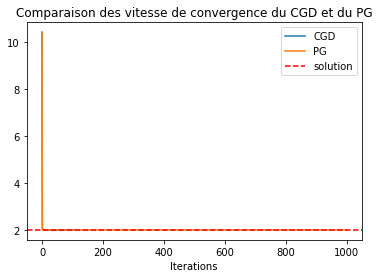

In [15]:
plt.plot(res_l2_GC["Valeurs"], label='CGD')
plt.plot(res_l2_PG["Valeurs"], label='PG')
plt.axhline(y=min_f_l2, label=r'solution', linestyle='--', color='red')
plt.title('Comparaison des vitesse de convergence du CGD et du PG')
plt.xlabel('Iterations')

plt.legend()
plt.show()

Dans le cas de la boule l2, le gradient contionnel et le gradient projeté convergent tous les deux vers la solution réelle, cependant l'algorithme du gradient projeté converge beaucoup plus vite(en seulement 2 itérations contre 46 pour le gradient conditionnel).

## Question 2: Contrainte: La boule L1

### Le gradient conditionnel sur la boule l-1

In [16]:
res_l1 = cond_grad(f, grad_f, x_0_l1, constr='l1', iter = 5000)

Convergence


<ipython-input-8-469a503b38db>:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultats_l1.loc['Gradient conditionnel']= np.array([opt_pt,minim,k])


### Le gradient projeté sur la boule l-1

In [17]:
L_l1=1/4

In [18]:
res_l1_PG = proj_gradient(f, grad_f, x_0_l1, L_l1, epsilon= 1e-8, constr = 'l1', iter = 5000)

Convergence


<ipython-input-9-99c45a546043>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultats_l1.loc['Gradient projeté']= np.array([opt_pt,minim,k])


### Comparaison des algorithmes du gradient condtionnel et du gradient projeté sur la boule l-1

In [19]:
resultats_l1

,x_opt,f(x_opt),nombre itérations
Gradient conditionnel,"[-0.62471, -0.37478]",2.43825,1138
Gradient projeté,"[-0.8, -0.6]",2.0,2
Valeurs réelles,"[-0.625, -0.375]",2.438,non défini


In [20]:
res_l1_PG = proj_gradient(f, grad_f, x_0_l1, L_l1, epsilon= 1e-8, constr = 'l1', iter = 1000,arret=False)

<ipython-input-9-99c45a546043>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultats_l1.loc['Gradient projeté']= np.array([opt_pt,minim,k])


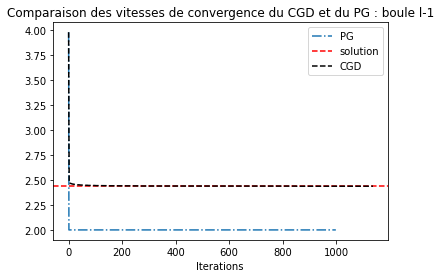

In [21]:
plt.plot(res_l1_PG["Valeurs"],  linestyle='-.',label='PG')
plt.axhline(y=min_f_l1, label=r'solution', linestyle='--', color='red')
plt.plot(res_l1["Valeurs"],label='CGD',  linestyle='--', color='black')
plt.title('Comparaison des vitesses de convergence du CGD et du PG : boule l-1')
plt.xlabel('Iterations ')
plt.legend()
plt.show()


Dans le cas de la boule l1, le gradient contionnel converge  vers la solution réelle tandis que le gradient projeté ne converge que vers un voisinage de la solution, cependant l'algorithme du gradient projeté converge beaucoup plus vite(en seulement 2 itérations contre 973 pour le gradient conditionnel).